<script async src="https://www.googletagmanager.com/gtag/js?id=UA-59152712-8"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-59152712-8');
</script>

# Start-to-Finish Example: Unit Testing `GiRaFFE_NRPy`: Interpolating Metric Face-Values

## Author: Patrick Nelson

## This module Validates the `FCVAL` routine for `GiRaFFE`.

**Notebook Status:** <font color='green'><b>Validated</b></font>

**Validation Notes:** This module will validate the routines in [Tutorial-GiRaFFE_NRPy-Metric_Face_Values](Tutorial-GiRaFFE_NRPy-Metric_Face_Values.ipynb).

### NRPy+ Source Code for this module: 
* [GiRaFFE_NRPy/GiRaFFE_NRPy_Metric_Face_Values.py](../../edit/in_progress/GiRaFFE_NRPy/GiRaFFE_NRPy_Metric_Face_Values.py) [\[**tutorial**\]](Tutorial-GiRaFFE_NRPy-FCVAL.ipynb) Generates the driver to compute the magnetic field from the vector potential in arbitrary spactimes.

## Introduction:

This notebook validates the code that will interpolate the metric gridfunctions on cell faces. These values, along with the reconstruction of primitive variables on the faces, are necessary for the Riemann solvers to compute the fluxes through the cell faces.

It is, in general, good coding practice to unit test functions individually to verify that they produce the expected and intended output. We will generate test data with arbitrarily-chosen analytic functions and calculate gridfunctions at the cell centers on a small numeric grid. We will then compute the values on the cell faces in two ways: first, with our interpolator, then second, we will shift the grid and compute them analytically. Then, we will rerun the function at a finer resolution. Finally, we will compare the results of the two runs to show third-order convergence.


<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

This notebook is organized as follows

1. [Step 1](#setup): Set up core functions and parameters for unit testing the FCVAL algorithm
    1. [Step 1.a](#expressions) Write expressions for the metric gridfunctions
    1. [Step 1.b](#ccodekernels) Generate C functions to calculate the gridfunctions
    1. [Step 1.c](#free_parameters) Set free parameters in the code
1. [Step 2](#mainc): `FCVAL_unit_test.c`: The Main C Code
    1. [Step 2.a](#compile_run): Compile and run the code
1. [Step 3](#convergence): Code validation: Verify that relative error in numerical solution converges to zero at the expected order
1. [Step 4](#latex_pdf_output): Output this notebook to $\LaTeX$-formatted PDF file

<a id='setup'></a>

# Step 1: Set up core functions and parameters for unit testing the FCVAL algorithm \[Back to [top](#toc)\]
$$\label{setup}$$

We'll start by appending the relevant paths to `sys.path` so that we can access sympy modules in other places. Then, we'll import NRPy+ core functionality and set up a directory in which to carry out our test. 

In [1]:
import shutil, os, sys           # Standard Python modules for multiplatform OS-level functions
# First, we'll add the parent directory to the list of directories Python will check for modules.
nrpy_dir_path = os.path.join("..")
if nrpy_dir_path not in sys.path:
    sys.path.append(nrpy_dir_path)
nrpy_dir_path = os.path.join("..","..")
if nrpy_dir_path not in sys.path:
    sys.path.append(nrpy_dir_path)

from outputC import *            # NRPy+: Core C code output module
import finite_difference as fin  # NRPy+: Finite difference C code generation module
import NRPy_param_funcs as par   # NRPy+: Parameter interface
import grid as gri               # NRPy+: Functions having to do with numerical grids
import loop as lp                # NRPy+: Generate C code loops
import indexedexp as ixp         # NRPy+: Symbolic indexed expression (e.g., tensors, vectors, etc.) support
import reference_metric as rfm   # NRPy+: Reference metric support
import cmdline_helper as cmd     # NRPy+: Multi-platform Python command-line interface

out_dir = "Validation/"
cmd.mkdir(out_dir)

thismodule = "Start_to_Finish_UnitTest-GiRaFFE_NRPy-Metric_Face_Values"

# Set the finite-differencing order to 2
par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER", 2)


<a id='expressions'></a>

## Step 1.a: Write expressions for the metric gridfunctions \[Back to [top](#toc)\]
$$\label{expressions}$$

Now, we'll choose some functions with arbitrary forms to generate test data. We'll need to set ten gridfunctions, so expressions are being pulled from several previously written unit tests.

\begin{align}
\gamma_{xx} &= ax^3 + by^3 + cz^3 + dy^2 + ez^2 + f \\
\gamma_{yy} &= gx^3 + hy^3 + lz^3 + mx^2 + nz^2 + p \\
\gamma_{zz} &= px^3 + qy^3 + rz^3 + sx^2 + ty^2 + u. \\
\gamma_{xy} &= a \exp\left(-\left((x-b)^2+(y-c)^2+(z-d)^2\right)\right) \\
\gamma_{xz} &= f \exp\left(-\left((x-g)^2+(y-h)^2+(z-l)^2\right)\right) \\
\gamma_{yz} &= m \exp\left(-\left((x-n)^2+(y-o)^2+(z-p)^2\right)\right), \\
\beta^x &= \frac{2}{\pi} \arctan(ax + by + cz) \\
\beta^y &= \frac{2}{\pi} \arctan(bx + cy + az) \\
\beta^z &= \frac{2}{\pi} \arctan(cx + ay + bz) \\
\alpha &= 1 - \frac{1}{2+x^2+y^2+z^2} \\
\end{align}


In [2]:
a,b,c,d,e,f,g,h,l,m,n,o,p,q,r,s,t,u = par.Cparameters("REAL",thismodule,["a","b","c","d","e","f","g","h","l","m","n","o","p","q","r","s","t","u"],1e300)
M_PI  = par.Cparameters("#define",thismodule,["M_PI"], "")

gammaDD = ixp.register_gridfunctions_for_single_rank2("AUXEVOL","gammaDD","sym01",DIM=3)
betaU = ixp.register_gridfunctions_for_single_rank1("AUXEVOL","betaU",DIM=3)
alpha = gri.register_gridfunctions("AUXEVOL","alpha")

par.set_parval_from_str("reference_metric::CoordSystem","Cartesian")
rfm.reference_metric()
x = rfm.xxCart[0]
y = rfm.xxCart[1]
z = rfm.xxCart[2]

gammaDD[0][0] = a*x**3 + b*y**3 + c*z**3 + d*y**2 + e*z**2 + f
gammaDD[1][1] = g*x**3 + h*y**3 + l*z**3 + m*x**2 + n*z**2 + o
gammaDD[2][2] = p*x**3 + q*y**3 + r*z**3 + s*x**2 + t*y**2 + u
gammaDD[0][1] = a * sp.exp(-((x-b)**2 + (y-c)**2 + (z-d)**2))
gammaDD[0][2] = f * sp.exp(-((x-g)**2 + (y-h)**2 + (z-l)**2))
gammaDD[1][2] = m * sp.exp(-((x-n)**2 + (y-o)**2 + (z-p)**2))

betaU[0] = (sp.sympify(2.0)/M_PI) * sp.atan(a*x + b*y + c*z)
betaU[1] = (sp.sympify(2.0)/M_PI) * sp.atan(b*x + c*y + a*z)
betaU[2] = (sp.sympify(2.0)/M_PI) * sp.atan(c*x + a*y + b*z)

alpha = sp.sympify(1.0) - sp.sympify(1.0) / (sp.sympify(2.0) + x**2 + y**2 + z**2)

<a id='ccodekernels'></a>

## Step 1.b: Generate C functions to calculate the gridfunctions \[Back to [top](#toc)\]
$$\label{ccodekernels}$$

Here, we will use the NRPy+ function `outCfunction()` to generate C code that will calculate our metric gridfunctions over an entire grid. We will also call the function to generate the function we are testing. 

In [3]:
metric_gfs_to_print = [\
                       lhrh(lhs=gri.gfaccess("aux_gfs","gammaDD00"),rhs=gammaDD[0][0]),\
                       lhrh(lhs=gri.gfaccess("aux_gfs","gammaDD01"),rhs=gammaDD[0][1]),\
                       lhrh(lhs=gri.gfaccess("aux_gfs","gammaDD02"),rhs=gammaDD[0][2]),\
                       lhrh(lhs=gri.gfaccess("aux_gfs","gammaDD11"),rhs=gammaDD[1][1]),\
                       lhrh(lhs=gri.gfaccess("aux_gfs","gammaDD12"),rhs=gammaDD[1][2]),\
                       lhrh(lhs=gri.gfaccess("aux_gfs","gammaDD22"),rhs=gammaDD[2][2]),\
                       lhrh(lhs=gri.gfaccess("aux_gfs","betaU0"),rhs=betaU[0]),\
                       lhrh(lhs=gri.gfaccess("aux_gfs","betaU1"),rhs=betaU[1]),\
                       lhrh(lhs=gri.gfaccess("aux_gfs","betaU2"),rhs=betaU[2]),\
                       lhrh(lhs=gri.gfaccess("aux_gfs","alpha"),rhs=alpha),\
                      ]

desc = "Calculate the metric gridfunctions"
name = "calculate_metric_gfs"
outCfunction(
    outfile  = os.path.join(out_dir,name+".h"), desc=desc, name=name,
    params   ="const paramstruct *restrict params,REAL *restrict xx[3],REAL *restrict auxevol_gfs",
    body     = fin.FD_outputC("returnstring",metric_gfs_to_print,params="outCverbose=False").replace("IDX4","IDX4S"),
    loopopts="AllPoints,Read_xxs")

import GiRaFFE_NRPy.GiRaFFE_NRPy_Metric_Face_Values as FCVAL
FCVAL.GiRaFFE_NRPy_FCVAL(out_dir)


Output C function calculate_metric_gfs() to file Validation/calculate_metric_gfs.h


<a id='free_parameters'></a>

## Step 1.c: Set free parameters in the code \[Back to [top](#toc)\]
$$\label{free_parameters}$$

We also need to create the files that interact with NRPy's C parameter interface. 

In [4]:
# Step 3.d.i: Generate declare_Cparameters_struct.h, set_Cparameters_default.h, and set_Cparameters[-SIMD].h
# par.generate_Cparameters_Ccodes(os.path.join(out_dir))

# Step 3.d.ii: Set free_parameters.h
with open(os.path.join(out_dir,"free_parameters.h"),"w") as file:
    file.write("""
// Override parameter defaults with values based on command line arguments and NGHOSTS.
params.Nxx0 = atoi(argv[1]);
params.Nxx1 = atoi(argv[2]);
params.Nxx2 = atoi(argv[3]);
params.Nxx_plus_2NGHOSTS0 = params.Nxx0 + 2*NGHOSTS;
params.Nxx_plus_2NGHOSTS1 = params.Nxx1 + 2*NGHOSTS;
params.Nxx_plus_2NGHOSTS2 = params.Nxx2 + 2*NGHOSTS;
// Step 0d: Set up space and time coordinates
// Step 0d.i: Declare \Delta x^i=dxx{0,1,2} and invdxx{0,1,2}, as well as xxmin[3] and xxmax[3]:
const REAL xxmin[3] = {-1.0,-1.0,-1.0};
const REAL xxmax[3] = { 1.0, 1.0, 1.0};

params.dxx0 = (xxmax[0] - xxmin[0]) / ((REAL)params.Nxx0);
params.dxx1 = (xxmax[1] - xxmin[1]) / ((REAL)params.Nxx1);
params.dxx2 = (xxmax[2] - xxmin[2]) / ((REAL)params.Nxx2);
printf("dxx0,dxx1,dxx2 = %.5e,%.5e,%.5e\\n",params.dxx0,params.dxx1,params.dxx2);
params.invdx0 = 1.0 / params.dxx0;
params.invdx1 = 1.0 / params.dxx1;
params.invdx2 = 1.0 / params.dxx2;
\n""")

# Generates declare_Cparameters_struct.h, set_Cparameters_default.h, and set_Cparameters[-SIMD].h
par.generate_Cparameters_Ccodes(os.path.join(out_dir))

<a id='mainc'></a>

# Step 2: `FCVAL_unit_test.c`: The Main C Code \[Back to [top](#toc)\]
$$\label{mainc}$$



In [5]:
%%writefile $out_dir/FCVAL_unit_test.c
// These are common packages that we are likely to need.
#include "stdio.h"
#include "stdlib.h"
#include "math.h"
#include "string.h" // Needed for strncmp, etc.
#include "stdint.h" // Needed for Windows GCC 6.x compatibility
#include <time.h>   // Needed to set a random seed.

#define REAL double
#include "declare_Cparameters_struct.h"

const int NGHOSTS = 3;

REAL a,b,c,d,e,f,g,h,l,m,n,o,p,q,r,s,t,u;

// Standard NRPy+ memory access:
#define IDX4S(g,i,j,k) \
( (i) + Nxx_plus_2NGHOSTS0 * ( (j) + Nxx_plus_2NGHOSTS1 * ( (k) + Nxx_plus_2NGHOSTS2 * (g) ) ) )

// Give gridfunctions their names:
#define GAMMADD00GF 0
#define GAMMADD01GF 1
#define GAMMADD02GF 2
#define GAMMADD11GF 3
#define GAMMADD12GF 4
#define GAMMADD22GF 5
#define BETAU0GF 6
#define BETAU1GF 7
#define BETAU2GF 8
#define ALPHAGF 9
#define GAMMA_FACEDD00GF 10
#define GAMMA_FACEDD01GF 11
#define GAMMA_FACEDD02GF 12
#define GAMMA_FACEDD11GF 13
#define GAMMA_FACEDD12GF 14
#define GAMMA_FACEDD22GF 15
#define BETA_FACEU0GF 16
#define BETA_FACEU1GF 17
#define BETA_FACEU2GF 18
#define ALPHA_FACEGF 19
#define NUM_AUXEVOL_GFS 20

#include "calculate_metric_gfs.h"
#include "interpolate_metric_gfs_to_cell_faces.h"

int main(int argc, const char *argv[]) {
    paramstruct params;
#include "set_Cparameters_default.h"

    // Step 0c: Set free parameters, overwriting Cparameters defaults 
    //          by hand or with command-line input, as desired.
#include "free_parameters.h"
#include "set_Cparameters-nopointer.h"

    // Step 0e: Set up cell-centered Cartesian coordinate grids
    REAL *xx[3];
    xx[0] = (REAL *)malloc(sizeof(REAL)*Nxx_plus_2NGHOSTS0);
    xx[1] = (REAL *)malloc(sizeof(REAL)*Nxx_plus_2NGHOSTS1);
    xx[2] = (REAL *)malloc(sizeof(REAL)*Nxx_plus_2NGHOSTS2);
    for(int j=0;j<Nxx_plus_2NGHOSTS0;j++) xx[0][j] = xxmin[0] + (j-NGHOSTS)*dxx0;
    for(int j=0;j<Nxx_plus_2NGHOSTS1;j++) xx[1][j] = xxmin[1] + (j-NGHOSTS)*dxx1;
    for(int j=0;j<Nxx_plus_2NGHOSTS2;j++) xx[2][j] = xxmin[2] + (j-NGHOSTS)*dxx2;
  
    //for(int i=0;i<Nxx_plus_2NGHOSTS0;i++) printf("xx[0][%d] = %.15e\n",i,xx[0][i]);

    // This is the array to which we'll write the NRPy+ variables.
    REAL *auxevol_gfs  = (REAL *)malloc(sizeof(REAL) * NUM_AUXEVOL_GFS * Nxx_plus_2NGHOSTS2 * Nxx_plus_2NGHOSTS1 * Nxx_plus_2NGHOSTS0);
    // And another for exact data: 
    REAL *auxevol_exact_gfs  = (REAL *)malloc(sizeof(REAL) * NUM_AUXEVOL_GFS * Nxx_plus_2NGHOSTS2 * Nxx_plus_2NGHOSTS1 * Nxx_plus_2NGHOSTS0);

    // Generate some random coefficients. Leave the random seed on its default for consistency between trials.
    a = (double)(rand()%20)/5.0;
    f = (double)(rand()%20)/5.0;
    m = (double)(rand()%20)/5.0;
    b = (double)(rand()%10-5)/100.0;
    c = (double)(rand()%10-5)/100.0;
    d = (double)(rand()%10-5)/100.0;
    g = (double)(rand()%10-5)/100.0;
    h = (double)(rand()%10-5)/100.0;
    l = (double)(rand()%10-5)/100.0;
    n = (double)(rand()%10-5)/100.0;
    o = (double)(rand()%10-5)/100.0;
    p = (double)(rand()%10-5)/100.0;

    // First, calculate the test data on our grid:
    calculate_metric_gfs(&params,xx,auxevol_gfs);
    // Now, run our function:
    int flux_dirn = 0;
    interpolate_metric_gfs_to_cell_faces(&params,auxevol_gfs,flux_dirn);
    // For comparison, shift the grid half a gridpoint, then calculate the test data again.
    REAL dxx[3] = {dxx0,dxx1,dxx2};
    REAL Nxxp2NG[3] = {Nxx_plus_2NGHOSTS0,Nxx_plus_2NGHOSTS1,Nxx_plus_2NGHOSTS2};
    for(int i=0;i<Nxxp2NG[flux_dirn];i++) {
        xx[flux_dirn][i] -= dxx[flux_dirn]/2.0;
    }
    calculate_metric_gfs(&params,xx,auxevol_exact_gfs);
    
    char filename[100];
    sprintf(filename,"out%d-numer.txt",Nxx0);
    FILE *out2D = fopen(filename, "w");
    for(int i2=0;i2<Nxx_plus_2NGHOSTS2;i2++) for(int i1=0;i1<Nxx_plus_2NGHOSTS1;i1++) for(int i0=0;i0<Nxx_plus_2NGHOSTS0;i0++) {
        // We print the difference between approximate and exact numbers.
        fprintf(out2D,"%.16e\t %e %e %e\n",
                auxevol_gfs[IDX4S(BETA_FACEU0GF,i0,i1,i2)]-auxevol_exact_gfs[IDX4S(BETAU0GF,i0,i1,i2)],
                xx[0][i0],xx[1][i1],xx[2][i2]
                );
    }
    fclose(out2D);
}

Overwriting Validation//FCVAL_unit_test.c


<a id='compile_run'></a>

## Step 2.a: Compile and run the code \[Back to [top](#toc)\]
$$\label{compile_run}$$

Now that we have our file, we can compile it and run the executable.

In [6]:
import time

print("Now compiling, should take ~2 seconds...\n")
start = time.time()
cmd.C_compile(os.path.join(out_dir,"FCVAL_unit_test.c"), os.path.join(out_dir,"FCVAL_unit_test"))
end = time.time()
print("Finished in "+str(end-start)+" seconds.\n\n")

print("Now running...\n")
start = time.time()
!./Validation/FCVAL_unit_test 10 10 10
# To do a convergence test, we'll also need a second grid with twice the resolution.
!./Validation/FCVAL_unit_test 20 20 20
end = time.time()
print("Finished in "+str(end-start)+" seconds.\n\n")


Now compiling, should take ~2 seconds...

Compiling executable...
Executing `gcc -Ofast -fopenmp -march=native -funroll-loops Validation/FCVAL_unit_test.c -o Validation/FCVAL_unit_test -lm`...
Finished executing in 0.41579604148864746 seconds.
Finished compilation.
Finished in 0.4259965419769287 seconds.


Now running...

dxx0,dxx1,dxx2 = 2.00000e-01,2.00000e-01,2.00000e-01
dxx0,dxx1,dxx2 = 1.00000e-01,1.00000e-01,1.00000e-01
Finished in 0.31423401832580566 seconds.




<a id='convergence'></a>

# Step 3: Code validation: Verify that relative error in numerical solution converges to zero at the expected order \[Back to [top](#toc)\]
$$\label{convergence}$$

Here, we import the data at two resolutions and wrote to text files. This data consists of the absolute error of a metric gridfunction at each in the grid. We'll plot a portion of this data along the axis at the lower resolution along with that same data at the higher resolution scaled to demonstrate that this error converges to 0 at the expected rate. Since our algorithm uses a third-order polynomial, we expect fourth-order convergence here.

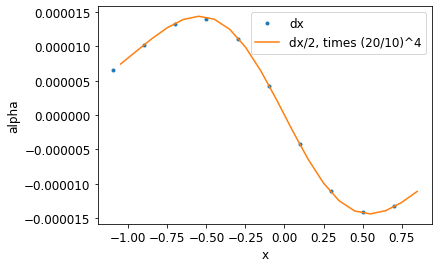

In [7]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 12})

Data1 = np.loadtxt("out10-numer.txt")
Data2 = np.loadtxt("out20-numer.txt")

def IDX4(i,j,k,Nxx_plus_2NGHOSTS0,Nxx_plus_2NGHOSTS1,Nxx_plus_2NGHOSTS2):
    return (i) + Nxx_plus_2NGHOSTS0 * ( (j) + Nxx_plus_2NGHOSTS1 * ( (k) + Nxx_plus_2NGHOSTS2 * (0) ) )

x1 = np.zeros(10)
a1 = np.zeros(10)
for i in range(10):
    x1[i] = Data1[IDX4(i+3,8,8,16,16,16),1]
    a1[i] = Data1[IDX4(i+3,8,8,16,16,16),0]
x2 = np.zeros(20)
a2 = np.zeros(20)
for i in range(20):
    x2[i] = Data2[IDX4(i+3,13,13,26,26,26),1]
    a2[i] = Data2[IDX4(i+3,13,13,26,26,26),0]

plt.figure()
a = plt.plot(x1,a1,'.',label="dx")
b = plt.plot(x2,a2*(2**4),label="dx/2, times (20/10)^4")
plt.legend()
plt.xlabel("x")
plt.ylabel("alpha")
plt.show()



<a id='latex_pdf_output'></a>

# Step 4: Output this notebook to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{latex_pdf_output}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-Start_to_Finish_UnitTest-GiRaFFE_NRPy-Metric_Face_Values.pdf](Tutorial-Start_to_Finish_UnitTest-GiRaFFE_NRPy-Metric_Face_Values.pdf) (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [8]:
!jupyter nbconvert --to latex --template latex_nrpy_style.tplx --log-level='WARN' Tutorial-Start_to_Finish_UnitTest-GiRaFFE_NRPy-Metric_Face_Values.ipynb
!pdflatex -interaction=batchmode Tutorial-Start_to_Finish_UnitTest-GiRaFFE_NRPy-Metric_Face_Values.tex
!pdflatex -interaction=batchmode Tutorial-Start_to_Finish_UnitTest-GiRaFFE_NRPy-Metric_Face_Values.tex
!pdflatex -interaction=batchmode Tutorial-Start_to_Finish_UnitTest-GiRaFFE_NRPy-Metric_Face_Values.tex
!rm -f Tut*.out Tut*.aux Tut*.log

This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
